In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import seaborn as sns
import pickle
import json
import re
import time
import sys
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

In [2]:
tdata = pd.read_csv('../src/data/raw/train.csv')
tdata['name'] = tdata['name'].isna().astype(int)
tdata['categories'] = tdata['categories'].isna().astype(int)
tdata['address'] = tdata['address'].isna().astype(int)
tdata['state'] = tdata['state'].isna().astype(int)
tdata['url'] = tdata['url'].isna().astype(int)
tdata['country'] = tdata['country'].isna().astype(int)

tdata = tdata[['id','name', 'categories', 'address', 'state', 
               'url', 'country']].drop_duplicates().reset_index(drop=True)

In [3]:
def prepare_data(df_set):
    
    train_df = []
    
    for i in range(1, 6):
    
        t1 = pd.read_csv('../src/data/processed/'+df_set+str(i)+'.csv')
        print(t1.shape)
        t1['kdist_diff'] = (t1['kdist'] - t1['kdist_country'])/t1['kdist_country']
        t1['kneighbors_mean'] = t1[['kneighbors', 'kneighbors_country']].mean(axis = 1)
        
        t1['sim_sum'] = t1[[col for col in t1.columns if 'sim' in col]].sum(axis=1)
        t1['gesh_sum'] = t1[[col for col in t1.columns if 'gesh' in col]].sum(axis=1)
        t1['leven_sum'] = t1[[col for col in t1.columns if '_leven' in col]].sum(axis=1)
        t1['jaro_sum'] = t1[[col for col in t1.columns if 'jaro' in col]].sum(axis=1)
        t1['lcs_sum'] = t1[[col for col in t1.columns if '_lcs' in col]].sum(axis=1)
        t1['nlcsk_sum'] = t1[[col for col in t1.columns if '_nlcsk' in col]].sum(axis=1)
        t1['nleven_sum'] = t1[[col for col in t1.columns if '_nleven' in col]].sum(axis=1)
        t1['nlcs_sum'] = t1[[col for col in t1.columns if '_nlcs' in col]].sum(axis=1)

        t1['sim_std'] = t1[[col for col in t1.columns if 'sim' in col]].std(axis=1)
        t1['gesh_std'] = t1[[col for col in t1.columns if 'gesh' in col]].std(axis=1)
        t1['leven_std'] = t1[[col for col in t1.columns if '_leven' in col]].std(axis=1)
        t1['jaro_std'] = t1[[col for col in t1.columns if 'jaro' in col]].std(axis=1)
        t1['lcs_std'] = t1[[col for col in t1.columns if '_lcs' in col]].std(axis=1)
        t1['nlcsk_std'] = t1[[col for col in t1.columns if '_nlcsk' in col]].std(axis=1)
        t1['nleven_std'] = t1[[col for col in t1.columns if '_nleven' in col]].std(axis=1)
        t1['nlcs_std'] = t1[[col for col in t1.columns if '_nlcs' in col]].std(axis=1)

        t1 = t1.merge(tdata, on='id', how='left')
        t1 = t1.merge(tdata, left_on='match_id', right_on='id', how='left', suffixes=['_1','_2'])
        t1 = t1.drop('id_2', axis=1).rename(columns={'id_1':'id'})
        
        t1['info_power_1'] = t1[[col for col in t1.columns if '_1' in col]].lt(1).sum(axis=1)
        t1['info_power_2'] = t1[[col for col in t1.columns if '_2' in col]].lt(1).sum(axis=1)
        t1['info_diff'] = t1['info_power_1'] - t1['info_power_2']
        
        train_df.append(t1)
        
        del t1
    
    return train_df

In [4]:
train_df = prepare_data('train_data_30n_')
train_df = pd.concat(train_df).reset_index(drop=True)

(3882850, 77)
(3886305, 77)
(3889652, 77)
(3879931, 77)
(3881083, 77)


In [5]:
train_df.shape

(19419821, 110)

In [6]:
valid_df = prepare_data('valid_data_30n_')
valid_df = pd.concat(valid_df).reset_index(drop=True)

(4226328, 77)
(4222560, 77)
(4221347, 77)
(4223522, 77)
(4224276, 77)


In [7]:
valid_df.shape

(21118033, 110)

In [8]:
train_df.label.value_counts()

0    18384909
1     1034912
Name: label, dtype: int64

In [9]:
valid_df.label.value_counts()

0    20080358
1     1037675
Name: label, dtype: int64

In [10]:
train_df = pd.concat([train_df, valid_df], axis=0).reset_index(drop=True)

del valid_df
gc.collect()

7

In [11]:
# FEATURES = ['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'name_sim', 'name_gesh','name_leven', 
#             'name_jaro', 'name_lcs', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'address_sim', 
#             'address_gesh', 'address_leven', 'address_jaro', 'address_lcs', 'address_len_diff', 'address_nleven', 
#             'address_nlcsk', 'address_nlcs', 'city_gesh', 'city_leven', 'city_jaro', 'city_lcs', 'city_len_diff', 
#             'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_sim', 'state_gesh', 'state_leven', 'state_jaro', 
#             'state_lcs', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'zip_gesh', 'zip_leven', 
#             'zip_jaro', 'zip_lcs', 'url_sim', 'url_gesh', 'url_leven', 'url_jaro', 'url_lcs', 'url_len_diff', 
#             'url_nleven', 'url_nlcsk', 'url_nlcs', 'phone_gesh', 'phone_leven', 'phone_jaro', 'phone_lcs', 
#             'categories_sim', 'categories_gesh', 'categories_leven', 'categories_jaro', 'categories_lcs', 
#             'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'country_sim', 
#             'country_gesh', 'country_leven', 'country_nleven', 'kdist_diff', 'kneighbors_mean', 
#             'name_1', 'categories_1', 'address_1', 'state_1', 'url_1', 'country_1', 'name_2',
#             'categories_2', 'address_2', 'state_2', 'url_2', 'country_2', 'sim_sum', 'gesh_sum',
#             'leven_sum', 'jaro_sum', 'lcs_sum', 'sim_std', 'gesh_std', 'leven_std',
#             'jaro_std', 'lcs_std', 'info_power_1', 'info_power_2', 'info_diff']


# cat_cols = []
# for col in FEATURES:
#     if train_df[col].nunique()<50:
#         cat_cols.append(col)
        
# print(len(cat_cols))

In [12]:
# cat_cols

In [13]:
TRAIN_FEATURES = ['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'name_sim', 'name_gesh','name_leven', 
                'name_jaro', 'name_lcs', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'address_sim', 
                'address_gesh', 'address_leven', 'address_jaro', 'address_lcs', 'address_len_diff', 'address_nleven', 
                'address_nlcsk', 'address_nlcs', 'city_gesh', 'city_leven', 'city_jaro', 'city_lcs', 'city_len_diff', 
                'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_sim', 'state_gesh', 'state_leven', 'state_jaro', 
                'state_lcs', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'zip_gesh', 'zip_leven', 
                'zip_jaro', 'zip_lcs', 'url_sim', 'url_gesh', 'url_leven', 'url_jaro', 'url_lcs', 'url_len_diff', 
                'url_nleven', 'url_nlcsk', 'url_nlcs', 'phone_gesh', 'phone_leven', 'phone_jaro', 'phone_lcs', 
                'categories_sim', 'categories_gesh', 'categories_leven', 'categories_jaro', 'categories_lcs', 
                'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'country_sim', 
                'country_gesh', 'country_leven', 'country_nleven', 'kdist_diff', 'kneighbors_mean', 
                'name_1', 'categories_1', 'address_1', 'state_1', 'url_1', 'country_1', 'name_2',
                'categories_2', 'address_2', 'state_2', 'url_2', 'country_2', 'sim_sum', 'gesh_sum',
                'leven_sum', 'jaro_sum', 'lcs_sum', 'sim_std', 'gesh_std', 'leven_std',
                'jaro_std', 'lcs_std', 'info_power_1', 'info_power_2', 'info_diff', 
                'nleven_sum', 'nlcsk_sum', 'nlcs_sum', 'nleven_std', 'nlcsk_std', 'nlcs_std']

In [14]:
NFOLDS = 5
kf = StratifiedKFold(n_splits = NFOLDS, shuffle=True, random_state=2018)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train_df, train_df["label"], train_df["label"]))):
    train_df.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

In [15]:
train_df.label.value_counts()/len(train_df)

0    0.948873
1    0.051127
Name: label, dtype: float64

In [16]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=15, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    
    models = []
    oof = np.zeros((len(y), n_class), dtype=np.float64)
    
    for i in tqdm(range(NFOLDS)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                verbose=50)
        else:
            with open(f'../src/models/BinaryModels/lgb_t30_2set_5f_binary{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = f'../src/models/BinaryModels/lgb_t30_2set_5f_binary{i}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [17]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'binary', 
    'tree_learner': 'feature',
    'metric': ['binary_logloss', 'AUC'],
    'learning_rate': 0.3,
    'reg_alpha': 0.1,
    'reg_lambda': 0.682,
    'random_state': 42,
    'max_depth': 9,
    'num_leaves': 127, 
    'n_estimators': 3000,
    "colsample_bytree": 0.785,
    "first_metric_only": True,
    "max_bin": 512,
    
    "bagging_fraction": 0.4086,
    "bagging_freq": 7,
    "subsample_for_bin": 300000,
    "min_data_in_leaf": 127
}

oof, models = fit_lgbm(train_df[TRAIN_FEATURES], train_df["label"].astype(int), 
                       params=params, n_class=int(train_df["label"].max() + 1), 
                       N_SPLITS=NFOLDS, folds=train_df["fold"].values)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[LightGBM] [Warning] bagging_fraction is set=0.4086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4086
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[50]	valid_0's binary_logloss: 0.032165	valid_0's auc: 0.994332
[100]	valid_0's binary_logloss: 0.030916	valid_0's auc: 0.994784
[150]	valid_0's binary_logloss: 0.0303392	valid_0's auc: 0.995003
[200]	valid_0's binary_logloss: 0.0298939	valid_0's auc: 0.995162
[250]	valid_0's binary_logloss: 0.0295236	valid_0's auc: 0.995274
[300]	valid_0's binary_logloss: 0.0293075	valid_0's auc: 0.99536
[350]	valid_0's binary_logloss: 0.0290859	valid_0's auc: 0.995432
[400]	valid_0's binary_logloss: 0.0288578	valid_0's auc: 0.995504
[450]	valid_0's binary_logloss: 0.0286775	valid_0's auc: 0.995566
[500]	valid_0's binary_logloss: 0.0285118	

[2700]	valid_0's binary_logloss: 0.0251091	valid_0's auc: 0.996612
[2750]	valid_0's binary_logloss: 0.0250507	valid_0's auc: 0.996631
[2800]	valid_0's binary_logloss: 0.0250078	valid_0's auc: 0.996638
[2850]	valid_0's binary_logloss: 0.0249521	valid_0's auc: 0.996657
[2900]	valid_0's binary_logloss: 0.0249023	valid_0's auc: 0.996672
[2950]	valid_0's binary_logloss: 0.0248504	valid_0's auc: 0.996691
[3000]	valid_0's binary_logloss: 0.0248123	valid_0's auc: 0.9967

== fold 2 ==
[LightGBM] [Warning] bagging_fraction is set=0.4086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4086
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[50]	valid_0's binary_logloss: 0.0320975	valid_0's auc: 0.994322
[100]	valid_0's binary_logloss: 0.0308948	valid_0's auc: 0.994772
[150]	valid_0's binary_logloss: 0

[2450]	valid_0's binary_logloss: 0.0252156	valid_0's auc: 0.996562
[2500]	valid_0's binary_logloss: 0.0251823	valid_0's auc: 0.996571
[2550]	valid_0's binary_logloss: 0.0251371	valid_0's auc: 0.996579
[2600]	valid_0's binary_logloss: 0.0250893	valid_0's auc: 0.996592
[2650]	valid_0's binary_logloss: 0.0250318	valid_0's auc: 0.996609
[2700]	valid_0's binary_logloss: 0.0249839	valid_0's auc: 0.996622
[2750]	valid_0's binary_logloss: 0.0249329	valid_0's auc: 0.996639
[2800]	valid_0's binary_logloss: 0.0248789	valid_0's auc: 0.996649
[2850]	valid_0's binary_logloss: 0.0248368	valid_0's auc: 0.996667
[2900]	valid_0's binary_logloss: 0.0247984	valid_0's auc: 0.996678
[2950]	valid_0's binary_logloss: 0.0247473	valid_0's auc: 0.996691
[3000]	valid_0's binary_logloss: 0.0247213	valid_0's auc: 0.9967

== fold 4 ==
[LightGBM] [Warning] bagging_fraction is set=0.4086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4086
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_s

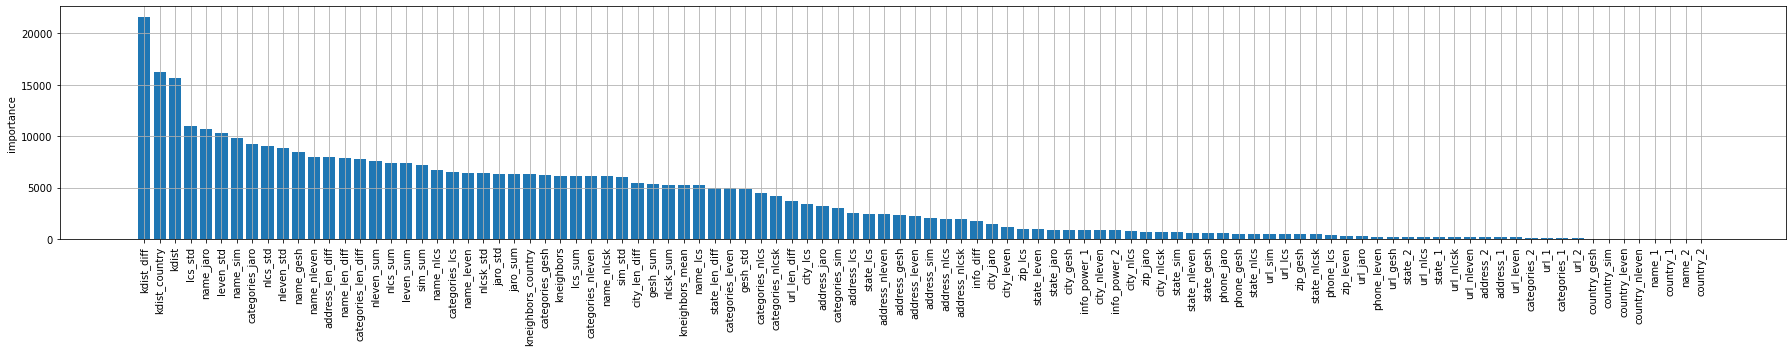

In [18]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=TRAIN_FEATURES, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(TRAIN_FEATURES) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

In [19]:
# !kaggle datasets init -p ../src/models/BinaryModels

In [20]:
# !kaggle datasets create -p ../src/models/BinaryModels --dir-mode zip

In [21]:
!kaggle datasets version -m "BothSets30n5Fold" -p ../src/models/BinaryModels --dir-mode zip

Starting upload for file lgb_2set_5f_binary0.pkl
100%|######################################| 39.7M/39.7M [00:07<00:00, 5.88MB/s]
Upload successful: lgb_2set_5f_binary0.pkl (40MB)
Starting upload for file lgb_5f_binary4.pkl
100%|######################################| 11.4M/11.4M [00:03<00:00, 3.66MB/s]
Upload successful: lgb_5f_binary4.pkl (11MB)
Starting upload for file lgb_2set_5f_binary3.pkl
100%|######################################| 39.6M/39.6M [00:05<00:00, 7.27MB/s]
Upload successful: lgb_2set_5f_binary3.pkl (40MB)
Starting upload for file lgb_t30_2set_5f_binary4.pkl
100%|######################################| 38.8M/38.8M [00:08<00:00, 4.70MB/s]
Upload successful: lgb_t30_2set_5f_binary4.pkl (39MB)
Starting upload for file lgb_t30_2set_5f_binary3.pkl
100%|######################################| 40.0M/40.0M [00:05<00:00, 7.82MB/s]
Upload successful: lgb_t30_2set_5f_binary3.pkl (40MB)
Starting upload for file lgb_2set_5f_binary1.pkl
100%|######################################| 